![](https://i.imgur.com/eBRPvWB.png)

# Practical PyTorch: Generating Shakespeare with a Character-Level RNN

[In the RNN classification tutorial](https://github.com/spro/practical-pytorch/blob/master/char-rnn-classification/char-rnn-classification.ipynb) we used a RNN to classify text one character at a time. This time we'll generate text one character at a time.

```
> python generate.py -n 500

PAOLTREDN:
Let, yil exter shis owrach we so sain, fleas,
Be wast the shall deas, puty sonse my sheete.

BAUFIO:
Sirh carrow out with the knonuot my comest sifard queences
O all a man unterd.

PROMENSJO:
Ay, I to Heron, I sack, againous; bepear, Butch,
An as shalp will of that seal think.

NUKINUS:
And house it to thee word off hee:
And thou charrota the son hange of that shall denthand
For the say hor you are of I folles muth me?
```

This one might make you question the series title &mdash; "is that really practical?" However, these sorts of generative models form the basis of machine translation, image captioning, question answering and more. See the [Sequence to Sequence Translation tutorial](https://github.com/spro/practical-pytorch/blob/master/seq2seq-translation/seq2seq-translation.ipynb) for more on that topic.

# Recommended Reading

I assume you have at least installed PyTorch, know Python, and understand Tensors:

* http://pytorch.org/ For installation instructions
* [Deep Learning with PyTorch: A 60-minute Blitz](https://github.com/pytorch/tutorials/blob/master/Deep%20Learning%20with%20PyTorch.ipynb) to get started with PyTorch in general
* [jcjohnson's PyTorch examples](https://github.com/jcjohnson/pytorch-examples) for an in depth overview
* [Introduction to PyTorch for former Torchies](https://github.com/pytorch/tutorials/blob/master/Introduction%20to%20PyTorch%20for%20former%20Torchies.ipynb) if you are former Lua Torch user

It would also be useful to know about RNNs and how they work:

* [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) shows a bunch of real life examples
* [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) is about LSTMs specifically but also informative about RNNs in general

Also see these related tutorials from the series:

* [Classifying Names with a Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/char-rnn-classification/char-rnn-classification.ipynb) uses an RNN for classification
* [Generating Names with a Conditional Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/conditional-char-rnn/conditional-char-rnn.ipynb) builds on this model to add a category as input

# setup

In [1]:
!pwd

/content


In [0]:
mkdir -p data

In [5]:
!ls -lah /content/

total 44K
drwxr-xr-x 1 root root 4.0K Apr 23 11:11 .
drwxr-xr-x 1 root root 4.0K Apr 23 04:36 ..
drwx------ 4 root root 4.0K Apr 23 11:10 .cache
drwxr-xr-x 3 root root 4.0K Apr 23 11:10 .config
drwxr-xr-x 1 root root 4.0K Apr 23 11:11 datalab
drwxr-xr-x 2 root root 4.0K Apr 23 11:11 drive
drwxr-xr-x 4 root root 4.0K Apr 23 04:37 .forever
drwx------ 3 root root 4.0K Apr 23 11:11 .gdfuse
drwxr-xr-x 5 root root 4.0K Apr 23 11:10 .ipython
drwx------ 3 root root 4.0K Apr 23 04:37 .local
-rw------- 1 root root 1.0K Apr 23 04:37 .rnd


In [5]:
!pip install unidecode

    100% |████████████████████████████████| 235kB 3.0MB/s 
You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [0]:
!pip install tqdm

In [0]:
# This only needs to be done once per notebook.
!pip install -U -q PyDrive

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

from pathlib import Path
import os

def download_and_save(file_name, file_id):
  downloaded = drive.CreateFile({'id': file_id})
  # fetch file
  downloaded.FetchContent()
  # write file
  with open(file_name,'wb') as f:
       f.write(downloaded.content.read())
      
  print(f'Saved {file_name}')

In [9]:
dataset_path = Path.home() / 'data'; dataset_path

PosixPath('/content/data')

In [11]:
# https://drive.google.com/open?id=1otbOB7GjKEVPjaPShaaTnYQnv-whwNWP
file_name = dataset_path / 'mickiewicz.txt'
file_id = '1otbOB7GjKEVPjaPShaaTnYQnv-whwNWP'

download_and_save(file_name, file_id)

Saved /content/data/mickiewicz.txt


# vm monitoring

In [0]:
import os
import psutil

def print_memsize():
  process = psutil.Process(os.getpid())
  print(f'{process.memory_info().rss / 1024**3:.5} GB')

In [3]:
print_memsize()

0.12249 GB


# Prepare data

The file we are using is a plain text file. We turn any potential unicode characters into plain ASCII by using the `unidecode` package (which you can install via `pip` or `conda`).

In [0]:
# fn = 'data/tiny-shakespeare.txt'
fn = 'data/mickiewicz.txt'

In [2]:
# import unidecode
import string
import random
import re

# file = unidecode.unidecode(open(fn).read())
file = open(fn).read()
file_len = len(file)
print('file_len =', file_len)

# ascii only
all_characters = string.printable
n_characters = len(all_characters)


# all chars found in file
all_characters = sorted(list(set(file)));
n_characters = len(all_characters)

file_len = 655594


To make inputs out of this big string of data, we will be splitting it into chunks.

In [3]:
chunk_len = 200

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

print(random_chunk())

ałt wysp i lądu brzegów:
To są północne świerki, sosny, jodły.
 
Gdzieniegdzie drzewa siekierą zrąbane,
Odarte i w stos złożone poziomy,
Tworzą kształt dziwny, jakby dach i ścianę,
I ludzi kryją, i zow


# Build the Model

This model will take as input the character for step $t_{-1}$ and is expected to output the next character $t$. There are three layers - one linear layer that encodes the input character into an internal state, one GRU layer (which may itself have multiple layers) that operates on that internal state and a hidden state, and a decoder layer that outputs the probability distribution.

In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

# Inputs and Targets

Each chunk will be turned into a tensor, specifically a `LongTensor` (used for integer values), by looping through the characters of the string and looking up the index of each character in `all_characters`.

In [5]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

print(char_tensor('ala ma kota'))

Variable containing:
 58
 69
 58
  3
 70
 58
  3
 68
 72
 77
 58
[torch.LongTensor of size 11]



Finally we can assemble a pair of input and target tensors for training, from a random chunk. The input will be all characters *up to the last*, and the target will be all characters *from the first*. So if our chunk is "abc" the input will correspond to "ab" while the target is "bc".

In [0]:
def random_training_set():    
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

# Evaluating

To evaluate the network we will feed one character at a time, use the outputs of the network as a probability distribution for the next character, and repeat. To start generation we pass a priming string to start building up the hidden state, from which we then generate one character at a time.

In [0]:
def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

# Training

A helper to print the amount of time passed:

In [0]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

The main training function

In [0]:
def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, target[c])

    loss.backward()
    decoder_optimizer.step()

    return loss.data[0] / chunk_len

Then we define the training parameters, instantiate the model, and start training:

In [10]:
n_epochs = 300 # 3000
print_every = 100
plot_every = 1
hidden_size = 100
n_layers = 1
lr = 0.005

decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
print(decoder)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

from tqdm import tqdm

for epoch in tqdm(range(1, n_epochs + 1)):
    loss = train(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        e = evaluate('Wh', 200)
        print('\n[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(e, '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

  0%|          | 0/300 [00:00<?, ?it/s]

RNN(
  (encoder): Embedding(172, 100)
  (gru): GRU(100, 100)
  (decoder): Linear(in_features=100, out_features=172)
)


 33%|███▎      | 100/300 [00:29<00:58,  3.44it/s]


 29s (100 33%) 2.7769]
Wh,   Czdą morze nieliecy krę stodzy  wiec ś piali sotrzekó momiciym ky srzyrzym granije; 
2tawniak podnera niaże brnie.
K     bię  l dochwiegłorzało kły  się po dodnierowny kowie.
     o kile,  bat, pł 



 67%|██████▋   | 200/300 [00:51<00:25,  3.87it/s]


 51s (200 66%) 2.7393]
Whch naj tają posłwowie, ---dty pogo pod jąc porówniem w jecza zarzyc.
 
IENERO
Nają cz wI ż.
Z mążniecz sta mach wsieby stajebie,
      Mustał,
   i małąś!  poleczy chy trza gwy.
 
I
Lo bię ny po stać  



100%|██████████| 300/300 [01:14<00:00,  4.03it/s]


 14s (300 100%) 2.1087]
Whmu jaj bóżni na.
SJI SAUчOST
Sły w wstaj! mom justąni: ny sył bydła - daska
R podkta, trzem szity nienie cię.
S. - monime przejami,
Wymia jaż nie gła wiet surzu przycierże nie  ninie! - Jaj zieb niedi 



# Plotting the Training Losses

Plotting the historical loss from all_losses shows the network learning:

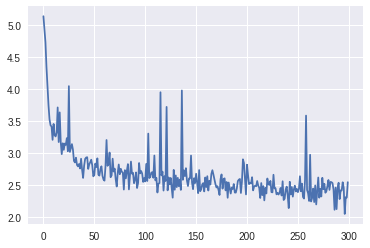

In [20]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

# Evaluating at different "temperatures"

In the `evaluate` function above, every time a prediction is made the outputs are divided by the "temperature" argument passed. Using a higher number makes all actions more equally likely, and thus gives us "more random" outputs. Using a lower value (less than 1) makes high probabilities contribute more. As we turn the temperature towards zero we are choosing only the most likely outputs.

We can see the effects of this by adjusting the `temperature` argument.

In [24]:
print(evaluate('Th', 200, temperature=0.8))

Thał, a połuszki?
Mały jej w drożąga z nalik z kończył popieczny okryż brapa,
Był się w naszej się się strugi się bietczę--
       je z moje wiecze pomory,
Oszajego kramiele bo widzieraz wpada mobieje s


Lower temperatures are less varied, choosing only the more probable outputs:

In [26]:
print(evaluate('Th', 200, temperature=0.2))

Tho mieszczył się podrował się się się się się wielki się nieszara,
Wierze się się pod przyjacień się wierczy,
A wiecznie się podrował, 
Wiedził się zapał się się się wierzy podrował,
Zabaczył się do do


Higher temperatures more varied, choosing less probable outputs:

In [25]:
print(evaluate('Th', 200, temperature=1.4))

ThÓ)

tańserych waląscie! Has romu leży.
Wojrźna? Lźitaty
szłysenne, kryjy rutu,
Od rycionabyfrapy; - posru;
Ni mrzewli, szmurek rzuży:
"Szrozabamiąli: WIFTą. SŁEMIÓN PISTNOść jakiasry, rąm3-słyśny, 
  


# Exercises

* Train with your own dataset, e.g.
    * Text from another author
    * Blog posts
    * Code
* Increase number of layers and network size to get better results

**Next**: [Generating Names with a Conditional Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/conditional-char-rnn/conditional-char-rnn.ipynb)

# save model

In [27]:
decoder.state_dict

<bound method Module.state_dict of RNN(
  (encoder): Embedding(172, 100)
  (gru): GRU(100, 100)
  (decoder): Linear(in_features=100, out_features=172)
)>

In [0]:
from pathlib import Path

In [22]:
model_path = Path('/content/data/') / 'model.h100.l1.cpu.dat'
torch.save(decoder, model_path)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
USE_GPU = False
model_path_cpu = Path('/content/data/') / 'model.h100.l1.cpu.dat'
cpu_model = torch.load(model_path_cpu)

In [0]:
def evaluate(prime_str='A', predict_len=100, temperature=0.8, decoder=None):
    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

In [8]:
print(evaluate('Th', 200, temperature=0.8)) #, decoder=cpu_model))

Thedzie panne pamiu, wie nie:
W dosto w zitędy drogo na znastał!
          Z z i mnie wdylawka iwsię   o skrzestoży wyrzenie)
Poży szapiemi,
Włyczudo dad żyj pota, w ży odnojąd nie zek o godo nieweta,
A


In [0]:
import pickle

In [17]:
!pip install dill

You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [0]:
import dill

In [0]:
dill.dump_session(Path('/content/data/') / 'session.cpu.dat')

In [0]:
dill.load_session(Path('/content/data/') / 'session.cpu.dat')